In [3]:
#INSTALL LIBRARIES------------------------------------------
!pip install transformers scikit-learn datasets wandb word2number
!pip install --upgrade ipykernel
!git clone https://github.com/monteleone-1883922/hw2_nlp.git
%cd hw2_nlp/
!git checkout huggingFaceBase
%cd ..
!cp hw2_nlp/manipulations.py .
!cp hw2_nlp/augmentation.py .
!rm -r hw2_nlp/

  Preparing metadata (setup.py) ... done
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5570 sha256=4467c43a9f8e25bdeaa313c11a7ee4a8529e241b8befb185dcbadcc8b249ed4d
  Stored in directory: /root/.cache/pip/wheels/84/ff/26/d3cfbd971e96c5aa3737ecfced81628830d7359b55fbb8ca3b
Successfully built word2number
Cloning into 'hw2_nlp'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 238 (delta 49), reused 45 (delta 20), pack-reused 159 (from 1)
Receiving objects: 100% (238/238), 1.01 MiB | 9.40 MiB/s, done.
Resolving deltas: 100% (145/145), done.
/content/hw2_nlp
Branch 'huggingFaceBase' set up to track remote branch 'huggingFaceBase' from 'origin'.
Switched to a new branch 'huggingFaceBase'
/content


In [4]:
#IMPORTS-----------------------------
from pprint import pprint
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from torch.nn import Linear, ReLU
import pdb
import numpy as np, torch, random as rnd, torch.nn as nn, wandb
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import sys, os, json
from transformers import AutoModelForQuestionAnswering
from torch.nn.functional import cosine_similarity
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import os, time
from augmentation import augment_data, augment_data_multithread
import random


In [5]:


adversarial = load_dataset("iperbole/adversarial_fever_nli")["test"]

ds = load_dataset("tommasobonomo/sem_augmented_fever_nli")

training_set = ds["train"]

validation_set = ds["validation"]

test_set = ds["test"]




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/73.1k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/337 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.1M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.25M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.25M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51086 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2288 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [6]:
random.seed(42)

training_set, new_data, info_augmentations = augment_data(training_set, 2000)

[nltk_data] Downloading package wordnet to /root/nltk_data...


[============================> ] 100.00% complete  Processing initial dataset 
 [31128, 12331, 7627]
[============================> ] 99.95% complete  Augmenting data 

In [10]:
grouped_data = {}
for sample in new_data:
    augment_value = sample['augment_method']
    grouped_data[augment_value] = grouped_data.get(augment_value, []) + [sample]
pprint(info_augmentations)

total_attempts = 0
total_successes = 0

# Itera attraverso il dizionario e somma i valori
for key, values in info_augmentations.items():
    total_attempts += values['count']
    total_successes += values['success']

# Stampa i risultati
print(f"Totale tentativi: {total_attempts}")
print(f"Totale successi: {total_successes}")

{'ANTINOMY_PART_PREMISE': {'count': 117, 'success': 117},
 'CHANGE_NUMBERS': {'count': 15, 'success': 15},
 'DUPLICATE_HYPOTHESIS': {'count': 282, 'success': 282},
 'HYPERNYM_HYPOTHESIS': {'count': 129, 'success': 101},
 'HYPONYM_PREMISE': {'count': 157, 'success': 154},
 'IMPOSSIBILITY': {'count': 125, 'success': 125},
 'NEGATE_HYPOTHESIS': {'count': 146, 'success': 146},
 'NEGATE_PART_PREMISE': {'count': 129, 'success': 121},
 'SWITCH_DATA': {'count': 163, 'success': 163},
 'SWITCH_PARTIAL_DATA': {'count': 154, 'success': 146},
 'SYNONYM': {'count': 153, 'success': 133},
 'TAKE_PART_PREMISE': {'count': 246, 'success': 246},
 'TAUTOLOGY': {'count': 250, 'success': 250},
 'TRUNCATE_HYPOTHESIS': {'count': 120, 'success': 1}}
Totale tentativi: 2186
Totale successi: 2000


In [20]:
pprint(grouped_data['CHANGE_NUMBERS'][3])

# NEGATE_PART_PREMISE = 1
#     # anything -> same thing
#     SYNONYM = 2
#     # anything -> negation
#     ANTINOMY_PART_PREMISE = 3
#     # anything -> same thing
#     HYPONYM_PREMISE = 4
#     # anything -> neutral
#     SWITCH_DATA = 5
#     # anything -> neutral
#     SWITCH_PARTIAL_DATA = 6
#     # anything -> entailment
#     TAKE_PART_PREMISE = 7
#     # entailment/negation -> opposite
#     NEGATE_HYPOTHESIS = 8
#     # anything -> same thing
#     HYPERNYM_HYPOTHESIS = 9
#     # anything -> negation
#     IMPOSSIBILITY = 10
#     # entailment -> entailment
#     TRUNCATE_HYPOTHESIS = 11
#     # anything -> entailment
#     TAUTOLOGY = 12
#     # anything -> entailment
#     DUPLICATE_HYPOTHESIS = 13
#     # entailment -> negation/entailment
#     CHANGE_NUMBERS = 14


{'augment_method': 'CHANGE_NUMBERS',
 'hypothesis': 'Michael Schumacher won 1 consecutive driving titles .',
 'label': 'CONTRADICTION',
 'old_hypothesis': 'Michael Schumacher won five consecutive driving titles.',
 'old_premise': 'Michael Schumacher . His time with Ferrari yielded five '
                'consecutive titles between and . Schumacher holds many of '
                "Formula One 's driver records , including most championships "
                ', race victories , fastest laps , pole positions and races '
                'won in a single season -- 13 in 2004 ( the last record was '
                'equalled by fellow German Sebastian Vettel nine years later ) '
                ". Schumacher won five consecutive drivers ' titles from 2000 "
                'to 2004 .',
 'premise': 'Michael Schumacher . His time with Ferrari yielded five '
            'consecutive titles between and . Schumacher holds many of Formula '
            "One 's driver records , including most cham

In [ ]:
print(training_set[0]['hypothesis'])
print(training_set[0]['premise'])
print(training_set[1]['hypothesis'])
print(training_set[1]['premise'])
print(training_set[2]['hypothesis'])
print(training_set[2]['premise'])

Roman Atwood is a content creator.
Roman Atwood . He is best known for his vlogs , where he posts updates about his life on a daily basis . His vlogging channel , `` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .
The Boston Celtics play their home games at TD Garden.
Boston Celtics . The Celtics play their home games at the TD Garden , which they share with the National Hockey League ( NHL ) 's Boston Bruins .
There is a movie called The Hunger Games.
The Hunger Games is a 2012 American dystopian science fiction adventure film directed by Gary Ross and based on the novel of the same name by Suzanne Collins . The film stars Jennifer Lawrence , Josh Hutcherson , Liam Hemsworth , Woody Harrelson , Elizabeth Banks , Lenny Kravitz , Stanley Tucci , and Donald Sutherland .


In [ ]:

# import nltk
# from nltk.corpus import stopwords

# nltk.download('stopwords')
# print(stopwords.words('english'))



In [ ]:
# f1 = "test per vedere come va"
# f2 = "questa è una prova"

# tokenized = tokenizer(f1+ tokenizer.eos_token + f2, return_tensors='pt', padding='max_length', max_length=40, return_token_type_ids=True)

# print(tokenized)
# print(tokenized["input_ids"].shape)
# print(type(tokenized))

# out = model(**tokenized)
# print(out['last_hidden_state'].shape)

# print(out.last_hidden_state.mean(dim=-1).squeeze().shape)

In [ ]:
# Function to print a progress bar
def print_progress_bar(percentuale: float, lunghezza_barra: int = 30, text: str="") -> None:
    blocchi_compilati = int(lunghezza_barra * percentuale)
    barra = "[" + "=" * (blocchi_compilati - 1) + ">" + " " * (lunghezza_barra - blocchi_compilati) + "]"
    sys.stdout.write(f"\r{barra} {percentuale * 100:.2f}% complete " + text)
    sys.stdout.flush()

In [ ]:
class NLIDataset(Dataset):



    def __init__(self, data, file_name, adversarial = False):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.encode_labels = {'CONTRADICTION': 0, 'NEUTRAL': 1, 'ENTAILMENT': 2}
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.model = RobertaModel.from_pretrained('roberta-base').to(self.device)
        self.distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
        self.file_name = file_name
        self.adversarial = adversarial
        self.preprocess_function(data)
        self.tokenizer = None
        self.model = None



    def preprocess_function(self, examples):
        premises = []
        answers = []
        hypothesis = []
        similarities = {}
        ordered_similarities = []
        file_exists = os.path.isfile("data/" + self.file_name)
        if file_exists:
            with open("data/" + self.file_name, "r") as f:
                similarities = json.load(f)
        # Utilizza un ciclo for per popolare le tre liste
        #breakpoint()
        for i,example in enumerate(examples):

            print_progress_bar(i / len(examples), text=" | preprocessing")
            premises.append(example["premise"].strip())
            answers.append(self.encode_labels[example["label"]] )
            hypothesis.append(example["hypothesis"].strip())
            if not file_exists:
                s1 = self.embed_sentence(example["premise"].strip())
                s2 = self.embed_sentence(example["hypothesis"].strip())
                if self.adversarial:


                    similarities[str(example["cid"]) + example["hypothesis"]] = cosine_similarity(s1, s2).item()
                    ordered_similarities.append(similarities[str(example["cid"]) + example["hypothesis"]])
                else:
                    similarities[example["id"]] = cosine_similarity(s1, s2).item()
                    ordered_similarities.append(similarities[example["id"]])
            elif self.adversarial:
                ordered_similarities.append(similarities[str(example["cid"]) + example["hypothesis"]])
            else:
                ordered_similarities.append(similarities[example["id"]])
        #breakpoint()
        inputs = self.distilbert_tokenizer(
            hypothesis,
            premises,
            max_length=384,
            truncation="only_second",
            return_offsets_mapping=True,
            padding="max_length",
            return_tensors="pt"
        )
        if not file_exists:
            if not os.path.exists("data"):
                os.makedirs("data")
            with open("data/" + self.file_name, "w") as f:
                json.dump(similarities, f, indent=4)
        inputs["label"] = torch.tensor(answers)
        inputs["similarity"] = torch.tensor(ordered_similarities)
        self.data = inputs


    def embed_sentence(self, sentence):
        # Tokenizza la frase
        inputs = self.tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
        # Ottieni gli embedding dal modello
        with torch.no_grad():
            outputs = self.model(**inputs.to(self.device))
        # Usa l'output del modello come embedding (puoi usare altri livelli o combinazioni se preferisci)
        # Prendi il vettore medio (puoi anche scegliere il vettore della [CLS] token, ecc.)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings

    def __len__(self):
        return len(self.data["input_ids"])

    def __getitem__(self, idx):
        return self.data["input_ids"][idx], self.data["attention_mask"][idx], self.data["label"][idx], self.data["similarity"][idx]

    def collate(self, batch):
        #breakpoint()
        x = []
        attention_mask = []
        y = []
        z = []
        for x_batch, attention_mask_batch, y_batch, z_batch in batch:
            x.append(x_batch)
            attention_mask.append(attention_mask_batch)
            y.append(y_batch)
            z.append(z_batch)

        x = torch.stack(x)
        attention_mask = torch.stack(attention_mask)
        y = torch.stack(y)
        z = torch.stack(z)
        #breakpoint()
        # x = pad_sequence(x, batch_first=True)
        # attention_mask = pad_sequence(attention_mask, batch_first=True)
        return x.to(self.device),attention_mask.to(self.device), y.to(self.device), z.to(self.device)



    def get_dataloader(self, batch_size):
        return DataLoader(self, batch_size=batch_size, shuffle=True, collate_fn = self.collate)

















In [ ]:
# prompt: create a torch model using roberta and a linear layer

class RobertaClassifier(nn.Module):
  def __init__(self, use_similarity, num_labels=3):
    super(RobertaClassifier, self).__init__()
    self.distilbert =  AutoModel.from_pretrained("distilbert/distilbert-base-uncased")
    self.linear = nn.Linear(self.distilbert.config.hidden_size+1, num_labels)
    self.use_similarity = use_similarity

  def freeze(self, epoch):
    if epoch == 2:
        freeze_until_layer = 99999
    else:
        freeze_until_layer = None  # Non congela nulla

    # Congela i layer di DistilBERT
    if freeze_until_layer is not None:
        for idx, param in enumerate(self.distilbert.parameters()):
            if idx < freeze_until_layer:
                param.requires_grad = False
            else:
                param.requires_grad = True



  def forward(self, input_ids, attention_mask, similarities):

   # breakpoint()
    if not self.use_similarity:
        similarities = torch.zeros(input_ids.shape[0]).to('cuda' if torch.cuda.is_available() else 'cpu')

    outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
    #breakpoint()

    pooled_output = torch.cat((outputs.last_hidden_state[:, 0, :], similarities.unsqueeze(1)), dim=1)
    # outputs.last_hidden_state.mean(dim=-1)

    logits = self.linear(pooled_output)

    return logits


In [ ]:


class Trainer():

    def __init__(self, model,train_dataloader, validation_dataloader, optimizer, loss_function, device):
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.validation_dataloader = validation_dataloader
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device


    @staticmethod
    def evaluation_parameters(y_true, y_pred):
        #breakpoint()
        y_pred = np.argmax(y_pred, axis=1)
        cm = confusion_matrix(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        accuracy = accuracy_score(y_true, y_pred)
        return cm, precision, recall, f1, accuracy

    @staticmethod
    def format_time_delay(seconds):
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        seconds = seconds % 60
        return hours, minutes, seconds


    def train(self, epochs: int, use_wandb: bool = False, config: dict = {}, name: str="", target_f1: float=0.0):
        start_time = time.time()
        best_model = None
        old_name = ''
        if use_wandb:
            wandb.init(
                # Set the project where this run will be logged
                project="nlphw2",
                name=name,
                # Track hyperparameters and run metadata
                config=config
            )
        validation_loss, precision, recall, f1, accuracy, cm = self.validate(use_wandb)
        total_loss = validation_loss
        if use_wandb:
                wandb.log({"validation_loss": validation_loss,
                      "precision": precision,
                      "recall": recall,
                      "f1": f1,
                      "accuracy": accuracy,
                      "train_loss": total_loss / len(self.train_dataloader)})
        for epoch in range(epochs):

            time_delay = time.time() - start_time
            hours, minutes, seconds = self.format_time_delay(time_delay)
            print(f"\nTempo trascorso: {hours} ore, {minutes} minuti, {seconds} secondi")
            self.model.freeze(epoch)
            self.model.train()  # Set the model to training mode
            total_loss = 0
            #breakpoint()
            for i, batch in enumerate(self.train_dataloader):
                print_progress_bar(i / len(self.train_dataloader), text=f" | training epoch {epoch}")
                # Get the inputs and targets from the batch
                inputs, mask, targets, similarities = batch

                # Zero the gradients
                self.optimizer.zero_grad()
                # Forward pass
                outputs = self.model(inputs, mask, similarities)
                #print("outputs = ", outputs,"\ntargets = ", targets)
                #breakpoint()
                # Compute loss
                loss = self.loss_function(outputs, targets)
                #print(loss)
                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()
                # Accumulate the total loss
                total_loss += loss.item()

            # Print the average loss for this epoch
            validation_loss, precision, recall, f1, accuracy, cm = self.validate(use_wandb)
            if f1 > target_f1:
                best_model = self.model.state_dict()
                target_f1 = f1
                if old_name != '':
                    os.remove(old_name)
                old_name = name + f'-{target_f1}.pth'
                torch.save(best_model, name + f'-{target_f1}.pth')
            if use_wandb:
                wandb.log({"validation_loss": validation_loss,
                      "precision": precision,
                      "recall": recall,
                      "f1": f1,
                      "accuracy": accuracy,
                      "train_loss": total_loss / len(self.train_dataloader)})
        print('\nbest f1: ', target_f1)
        if use_wandb:
            wandb.finish()



    def validate(self, use_wandb: bool = False, test_dataloader=False, load_from=''):
        if os.path.isfile(load_from):
            self.model.load_state_dict(torch.load(load_from, map_location=torch.device('cpu')))
        dataloader = self.validation_dataloader if test_dataloader is None else test_dataloader
        if dataloader is None:
            print("empty dataloader!")
            exit(1)
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0
        all_predictions = torch.tensor([])
        all_targets = torch.tensor([])
        with torch.no_grad():  # Do not calculate gradients
            for i, batch in enumerate(dataloader):
                print_progress_bar(i / len(dataloader), text=" | validation")
                # Get the inputs and targets from the batch
                inputs, mask, targets, similarities  = batch

                # Forward pass
                outputs = self.model(inputs, mask, similarities)
                # Compute loss
                #breakpoint()
                loss = self.loss_function(outputs, targets)
                # Accumulate the total loss
                total_loss += loss.item()
                # Store predictions and targets
                all_predictions = torch.cat((all_predictions, outputs.squeeze().round().cpu()))
                all_targets = torch.cat((all_targets, targets.cpu()))
        validation_loss = total_loss / len(self.validation_dataloader)
        #breakpoint()
        cm, precision, recall, f1, accuracy = self.evaluation_parameters(all_targets, all_predictions)
        return validation_loss, precision, recall, f1, accuracy, cm




In [ ]:
class BaselineStratifiedModel(nn.Module):

    def __init__(self, len0, len1):
        super(BaselineStratifiedModel, self).__init__()
        self.p = len0/(len0+len1)

    def forward(self, x):
        return torch.tensor([0 if np.random.rand() < self.p else 1 for _ in range(x[0].shape[0])], dtype=torch.float)



In [ ]:
new_seed = 108
def set_seed(seed):
    np.random.seed(seed)
    rnd.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # Se stai usando GPU
    return seed, seed+1

In [ ]:


# Imposta il seed per avere riproducibilità

seed, new_seed = set_seed(new_seed)

In [ ]:

adversarial = load_dataset("iperbole/adversarial_fever_nli")["test"]

ds = load_dataset("tommasobonomo/sem_augmented_fever_nli")

training_set = ds["train"]

validation_set = ds["validation"]

test_set = ds["test"]

wandb.login(key='aaf831dabc88d936d4e6b439b798bb4cb42814ea')

wandb: Currently logged in as: monteleone-1883922 (monteleone). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/studio-lab-user/.netrc


True

In [ ]:
# !git clone https://github.com/monteleone-1883922/hw2_nlp.git
# os.chdir("hw2_nlp")
# !git checkout huggingFaceBase
# !mv data ./../data
# os.chdir("..")
# !rm -rf hw2_nlp


In [ ]:
train_dataset = NLIDataset(training_set, "train_similarities.json")

validation_dataset = NLIDataset(validation_set, "validation_similarities.json")

test_dataset = NLIDataset(test_set, "test_similarities.json")

adversarial_dataset = NLIDataset(adversarial, "adversarial_similarities.json", adversarial=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[============================> ] 100.00% complete  | preprocessing

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[============================> ] 99.96% complete  | preprocessing

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[============================> ] 99.96% complete  | preprocessing

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[============================> ] 99.70% complete  | preprocessing

In [ ]:
# prompt: genera i dataloader

train_dataloader = train_dataset.get_dataloader(batch_size=50)
validation_dataloader = validation_dataset.get_dataloader(batch_size=50)
test_dataloader = test_dataset.get_dataloader(batch_size=32)
adversarial_dataloader = adversarial_dataset.get_dataloader(batch_size=32)


In [ ]:

model = RobertaClassifier(False)

trainer = Trainer(model, train_dataloader, validation_dataloader, torch.optim.Adam(model.parameters(), lr=1e-4), nn.CrossEntropyLoss(),'cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:
# trainer.validate(test=False)

In [ ]:

trainer.train(6, use_wandb=True, name="base_1e-4_"+ str(seed))




accuracy,▁
f1,▁
precision,▁
recall,▁
train_loss,▁
validation_loss,▁
accuracy,0.33916
f1,0.18635
precision,0.23085
recall,0.33916
train_loss,0.00108


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[============================> ] 97.83% complete  | validation
Tempo trascorso: 0.0 ore, 0.0 minuti, 34.245356798172 secondi
[>                              ] 0.00% complete  | training epoch 0

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[============================> ] 97.83% complete  | validationpoch 0
Tempo trascorso: 0.0 ore, 25.0 minuti, 7.745106935501099 secondi
[============================> ] 97.83% complete  | validationpoch 1
Tempo trascorso: 0.0 ore, 49.0 minuti, 42.715383768081665 secondi
[============================> ] 97.83% complete  | validationpoch 2
Tempo trascorso: 0.0 ore, 59.0 minuti, 26.580618858337402 secondi
[============================> ] 97.83% complete  | validationpoch 3
Tempo trascorso: 1.0 ore, 9.0 minuti, 11.667790174484253 secondi
[============================> ] 97.83% complete  | validationpoch 4
Tempo trascorso: 1.0 ore, 18.0 minuti, 54.596988916397095 secondi
[============================> ] 97.83% complete  | validationpoch 50.7284320746977797


accuracy,▁██████
f1,▁██████
precision,▁██████
recall,▁██████
train_loss,▁█▆▄▄▄▄
validation_loss,█▁▁▃▄▄▄
accuracy,0.73689
f1,0.72843
precision,0.73511
recall,0.73689
train_loss,0.2251


In [ ]:
validation_loss_1, precision_1, recall_1, f1_1, accuracy_1, cm_1 = trainer.validate(test_dataloader=test_dataloader, load_from='simil_1e-5_108-0.7299378113069238.pth')

validation_loss_2, precision_2, recall_2, f1_2, accuracy_2, cm_2 = trainer.validate(test_dataloader=adversarial_dataloader, load_from='simil_1e-5_108-0.7299378113069238.pth')


/tmp/ipykernel_110/1919384173.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(load_from, map_location=torch.device('cpu')))


[============================> ] 98.61% complete  | validation

/tmp/ipykernel_110/1919384173.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(load_from, map_location=torch.device('cpu')))


[==========================>   ] 90.91% complete  | validation

In [ ]:
print(f1_1)
print(f1_2)
print(type(cm_1))

# Visualizza la matrice di confusione


0.6916480330296884
0.54832453943422
<class 'numpy.ndarray'>


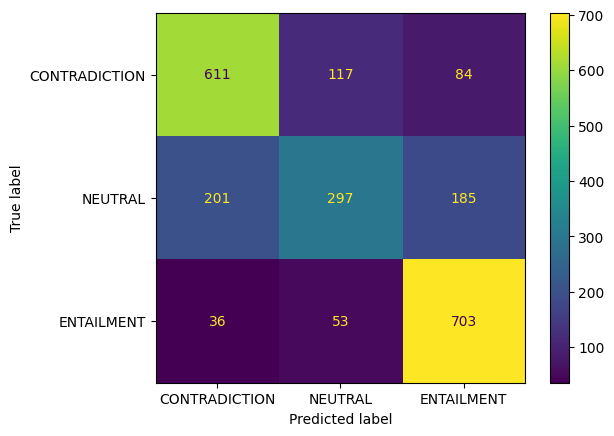

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=['CONTRADICTION', 'NEUTRAL','ENTAILMENT' ])
disp.plot()

# Se stai lavorando in un ambiente interattivo come Jupyter Notebook, la matrice verrà visualizzata automaticamente
# Se sei in uno script Python, puoi usare plt.show() per visualizzare la matrice

plt.show()

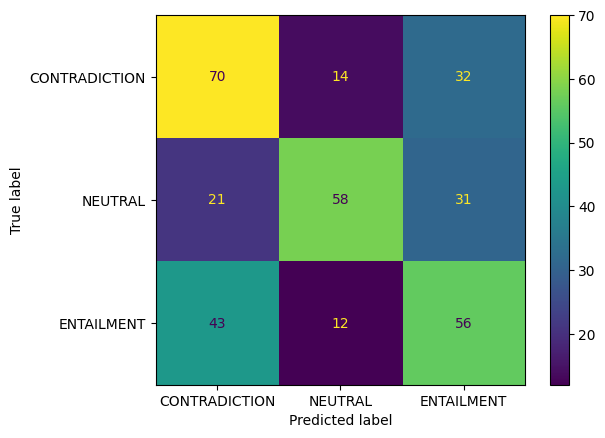

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=['CONTRADICTION', 'NEUTRAL','ENTAILMENT' ])
disp.plot()

plt.show()

In [ ]:
# del training_set

# dataset = NLIDataset(validation_set)


# dataloader = dataset.get_dataloader(batch_size=32, pos_num=1)

# model = RobertaClassifier()

# batch = next(iter(dataloader))

# model(batch[0], batch[1], batch[3])